# Train GME Model
This notebook will develop and train a neural network to predict the percent change in the GME price.
It will utilize grid search to find the best hyperparameters

## Enviornment setups

In [15]:
# Import packages

# General Utility
from datetime import datetime
import datetime, time
from datetime import timedelta

# Data processing
import numpy as np
import pandas as pd
import pickle
from sklearn.preprocessing import RobustScaler

# Plotting
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

import torch

# Diamond-Hands
import sys
sys.path.append('../Packages/')
import diamond_hands as dh

In [2]:
tickr = 'GME'

In [3]:
# Data Locations
processed_input_dir = '../../Data/ProcessedInputs/'
model_dir = '../../Data/Models/'
grid_result_dir = model_dir+tickr+'/'
fine_grid_result_dir = model_dir+tickr+'/Fine/'
pred_dir = '../../Data/Predictions/'
final_model_dir = '../../Data/Models/Final/'

In [4]:
TRAIN_ON_GPU, TRAIN_ON_MULTI_GPUS = dh.setupPytorch()

Training on GPU!


In [5]:
with open(processed_input_dir+tickr+'_input_data.bin','rb') as f:
    df = pickle.load(f)
with open(processed_input_dir+tickr+'_output_data.bin','rb') as f:
    output_data = pickle.load(f)
with open(model_dir+tickr+'_scaler.bin','rb') as f:
    scaler = pickle.load(f)

In [6]:
df = df[:-1]

In [7]:
df['2021-03-01':]

,P_Change,volume_adi,volume_obv,volume_cmf,volume_fi,volume_mfi,volume_em,volume_sma_em,volume_vpt,volume_nvi,...,Tomorrow_Tickr_#Pos,Tomorrow_Tickr_W#Neg,Tomorrow_Tickr_W#Neu,Tomorrow_Tickr_W#Pos,Tomorrow_Tickr_%Neg,Tomorrow_Tickr_%Neu,Tomorrow_Tickr_%Pos,Tomorrow_Tickr_W%Neg,Tomorrow_Tickr_W%Neu,Tomorrow_Tickr_W%Pos
Date,,,,,,,,,,,,,,,,,,,,,
2021-03-01,3.910138,-4.035378,10.850200,-1.805731,856.861237,0.734893,13.897788,46.966025,32.752498,0.674619,...,637.0,828.0,10069.0,4000.0,0.110599,0.522465,0.366935,0.048991,0.595764,0.236672
2021-03-02,1.574388,-4.218655,10.569685,-1.738399,721.082603,0.891975,28.614155,61.518156,87.205313,0.647886,...,947.0,2423.0,11010.0,6677.0,0.113694,0.486052,0.400254,0.108489,0.492970,0.298961
2021-03-03,0.670549,-4.094421,10.729568,-1.528435,638.664552,0.898975,-13.875294,56.537550,3.618222,0.720136,...,482.0,873.0,4416.0,6481.0,0.112724,0.475662,0.411614,0.069706,0.352603,0.517486
2021-03-04,0.836666,-4.075114,11.000354,-1.417334,594.920772,1.005502,89.653867,77.495389,31.985433,0.720136,...,498.0,2503.0,7208.0,4762.0,0.110488,0.490793,0.398719,0.166523,0.479542,0.316812
2021-03-05,6.877860,-4.132439,11.256018,-1.129193,539.515358,1.055707,49.818609,87.790705,34.817226,0.781034,...,482.0,938.0,10549.0,5087.0,0.081222,0.559613,0.359165,0.053271,0.599103,0.288903
2021-03-08,13.380670,-3.735486,11.784895,-0.750570,1106.897437,1.205790,319.089703,153.397597,281.773838,0.781034,...,957.0,6023.0,16373.0,15295.0,0.105004,0.502461,0.392535,0.150601,0.409397,0.382442
2021-03-09,7.837603,-3.315321,12.107815,-0.423055,1312.033693,1.298385,433.919575,246.175188,376.281635,1.200297,...,1119.0,5607.0,19581.0,17878.0,0.098531,0.500537,0.400932,0.121706,0.425027,0.388062
2021-03-10,-3.402873,-3.266709,12.702877,-0.336148,1355.825930,1.442558,616.167275,373.962389,161.172428,1.200297,...,805.0,3535.0,14051.0,11403.0,0.133752,0.477547,0.388701,0.107079,0.425620,0.345409
2021-03-11,4.554707,-3.223669,12.467844,-0.229213,1136.907119,1.226244,-44.533420,366.982303,48.343692,1.163024,...,531.0,2248.0,8043.0,4866.0,0.113605,0.525170,0.361224,0.132274,0.473257,0.286320


In [8]:
n_test=37

## Grid Search

In [9]:
# Configure search space
n_features = [df.shape[1]]
n_periods = [1,5,10,20,40,60]
n_hidden = [10,50,100]
n_layers = [2,3]
drop_prob = [0.1,0.25,0.5]
lr = [0.001,0.01]
clip = [1,5,10]
batch_size = [400]

In [10]:
# use grid search to optimize hyperparameters
grid_result = []
dh.gridSearch(grid_results = grid_result,
              tickr=tickr,
                           n_features=n_features,
                           n_periods=n_periods,
                           n_hidden=n_hidden,
                           n_layers=n_layers,
                           drop_prob=drop_prob,
                           lr=lr,
                           clip=clip,
                           batch_size=batch_size,
                           data=df,
                           epochs=10,
                           n_test=n_test,
                           n_steps_out=1,
                          fpath=grid_result_dir,
                           TRAIN_ON_GPU=TRAIN_ON_GPU,
                           TRAIN_ON_MULTI_GPUS=TRAIN_ON_MULTI_GPUS)

Hyper Parameter search across 648 different configurations.
Iteration: 1 |periods: 1|hidden: 10|layers: 2|drop: 0.1|lr: 0.001|clip: 1


C:\Environments\python37\lib\site-packages\torch\cuda\nccl.py:16: UserWarning: PyTorch is not compiled with NCCL support
  warnings.warn('PyTorch is not compiled with NCCL support')


Training complete in 0m 29s
Iteration: 2 |periods: 5|hidden: 10|layers: 2|drop: 0.1|lr: 0.001|clip: 1
Training complete in 0m 9s
Iteration: 3 |periods: 10|hidden: 10|layers: 2|drop: 0.1|lr: 0.001|clip: 1
Training complete in 0m 10s
Iteration: 4 |periods: 20|hidden: 10|layers: 2|drop: 0.1|lr: 0.001|clip: 1
Training complete in 0m 12s
Iteration: 5 |periods: 40|hidden: 10|layers: 2|drop: 0.1|lr: 0.001|clip: 1
Training complete in 0m 23s
Iteration: 6 |periods: 60|hidden: 10|layers: 2|drop: 0.1|lr: 0.001|clip: 1
Training complete in 0m 32s
Iteration: 7 |periods: 1|hidden: 50|layers: 2|drop: 0.1|lr: 0.001|clip: 1
Training complete in 0m 10s
Iteration: 8 |periods: 5|hidden: 50|layers: 2|drop: 0.1|lr: 0.001|clip: 1
Training complete in 0m 13s
Iteration: 9 |periods: 10|hidden: 50|layers: 2|drop: 0.1|lr: 0.001|clip: 1
Training complete in 0m 16s
Iteration: 10 |periods: 20|hidden: 50|layers: 2|drop: 0.1|lr: 0.001|clip: 1
Training complete in 0m 21s
Iteration: 11 |periods: 40|hidden: 50|layers: 2|

Training complete in 0m 15s
Iteration: 81 |periods: 10|hidden: 50|layers: 2|drop: 0.5|lr: 0.001|clip: 1
Training complete in 0m 16s
Iteration: 82 |periods: 20|hidden: 50|layers: 2|drop: 0.5|lr: 0.001|clip: 1
Training complete in 0m 20s
Iteration: 83 |periods: 40|hidden: 50|layers: 2|drop: 0.5|lr: 0.001|clip: 1
Training complete in 0m 28s
Iteration: 84 |periods: 60|hidden: 50|layers: 2|drop: 0.5|lr: 0.001|clip: 1
Training complete in 0m 38s
Iteration: 85 |periods: 1|hidden: 100|layers: 2|drop: 0.5|lr: 0.001|clip: 1
Training complete in 0m 11s
Iteration: 86 |periods: 5|hidden: 100|layers: 2|drop: 0.5|lr: 0.001|clip: 1
Training complete in 0m 14s
Iteration: 87 |periods: 10|hidden: 100|layers: 2|drop: 0.5|lr: 0.001|clip: 1
Training complete in 0m 18s
Iteration: 88 |periods: 20|hidden: 100|layers: 2|drop: 0.5|lr: 0.001|clip: 1
Training complete in 0m 23s
Iteration: 89 |periods: 40|hidden: 100|layers: 2|drop: 0.5|lr: 0.001|clip: 1
Training complete in 0m 31s
Iteration: 90 |periods: 60|hidden

Training complete in 0m 19s
Iteration: 160 |periods: 20|hidden: 100|layers: 2|drop: 0.25|lr: 0.01|clip: 1
Training complete in 0m 23s
Iteration: 161 |periods: 40|hidden: 100|layers: 2|drop: 0.25|lr: 0.01|clip: 1
Training complete in 0m 33s
Iteration: 162 |periods: 60|hidden: 100|layers: 2|drop: 0.25|lr: 0.01|clip: 1
Training complete in 0m 46s
Iteration: 163 |periods: 1|hidden: 10|layers: 3|drop: 0.25|lr: 0.01|clip: 1
Training complete in 0m 12s
Iteration: 164 |periods: 5|hidden: 10|layers: 3|drop: 0.25|lr: 0.01|clip: 1
Training complete in 0m 17s
Iteration: 165 |periods: 10|hidden: 10|layers: 3|drop: 0.25|lr: 0.01|clip: 1
Training complete in 0m 21s
Iteration: 166 |periods: 20|hidden: 10|layers: 3|drop: 0.25|lr: 0.01|clip: 1
Training complete in 0m 28s
Iteration: 167 |periods: 40|hidden: 10|layers: 3|drop: 0.25|lr: 0.01|clip: 1
Training complete in 0m 45s
Iteration: 168 |periods: 60|hidden: 10|layers: 3|drop: 0.25|lr: 0.01|clip: 1
Training complete in 0m 57s
Iteration: 169 |periods: 1

Training complete in 0m 29s
Iteration: 239 |periods: 40|hidden: 10|layers: 3|drop: 0.1|lr: 0.001|clip: 5
Training complete in 0m 44s
Iteration: 240 |periods: 60|hidden: 10|layers: 3|drop: 0.1|lr: 0.001|clip: 5
Training complete in 0m 60s
Iteration: 241 |periods: 1|hidden: 50|layers: 3|drop: 0.1|lr: 0.001|clip: 5
Training complete in 0m 13s
Iteration: 242 |periods: 5|hidden: 50|layers: 3|drop: 0.1|lr: 0.001|clip: 5
Training complete in 0m 17s
Iteration: 243 |periods: 10|hidden: 50|layers: 3|drop: 0.1|lr: 0.001|clip: 5
Training complete in 0m 20s
Iteration: 244 |periods: 20|hidden: 50|layers: 3|drop: 0.1|lr: 0.001|clip: 5
Training complete in 0m 30s
Iteration: 245 |periods: 40|hidden: 50|layers: 3|drop: 0.1|lr: 0.001|clip: 5
Training complete in 0m 46s
Iteration: 246 |periods: 60|hidden: 50|layers: 3|drop: 0.1|lr: 0.001|clip: 5
Training complete in 1m 2s
Iteration: 247 |periods: 1|hidden: 100|layers: 3|drop: 0.1|lr: 0.001|clip: 5
Training complete in 0m 14s
Iteration: 248 |periods: 5|hid

Training complete in 0m 32s
Iteration: 317 |periods: 40|hidden: 50|layers: 3|drop: 0.5|lr: 0.001|clip: 5
Training complete in 0m 48s
Iteration: 318 |periods: 60|hidden: 50|layers: 3|drop: 0.5|lr: 0.001|clip: 5
Training complete in 1m 7s
Iteration: 319 |periods: 1|hidden: 100|layers: 3|drop: 0.5|lr: 0.001|clip: 5
Training complete in 0m 15s
Iteration: 320 |periods: 5|hidden: 100|layers: 3|drop: 0.5|lr: 0.001|clip: 5
Training complete in 0m 19s
Iteration: 321 |periods: 10|hidden: 100|layers: 3|drop: 0.5|lr: 0.001|clip: 5
Training complete in 0m 25s
Iteration: 322 |periods: 20|hidden: 100|layers: 3|drop: 0.5|lr: 0.001|clip: 5
Training complete in 0m 35s
Iteration: 323 |periods: 40|hidden: 100|layers: 3|drop: 0.5|lr: 0.001|clip: 5
Training complete in 0m 56s
Iteration: 324 |periods: 60|hidden: 100|layers: 3|drop: 0.5|lr: 0.001|clip: 5
Training complete in 1m 16s
Iteration: 325 |periods: 1|hidden: 10|layers: 2|drop: 0.1|lr: 0.01|clip: 5
Training complete in 0m 13s
Iteration: 326 |periods: 5

Training complete in 0m 47s
Iteration: 396 |periods: 60|hidden: 100|layers: 3|drop: 0.25|lr: 0.01|clip: 5
Training complete in 1m 8s
Iteration: 397 |periods: 1|hidden: 10|layers: 2|drop: 0.5|lr: 0.01|clip: 5
Training complete in 0m 11s
Iteration: 398 |periods: 5|hidden: 10|layers: 2|drop: 0.5|lr: 0.01|clip: 5
Training complete in 0m 13s
Iteration: 399 |periods: 10|hidden: 10|layers: 2|drop: 0.5|lr: 0.01|clip: 5
Training complete in 0m 15s
Iteration: 400 |periods: 20|hidden: 10|layers: 2|drop: 0.5|lr: 0.01|clip: 5
Training complete in 0m 20s
Iteration: 401 |periods: 40|hidden: 10|layers: 2|drop: 0.5|lr: 0.01|clip: 5
Training complete in 0m 29s
Iteration: 402 |periods: 60|hidden: 10|layers: 2|drop: 0.5|lr: 0.01|clip: 5
Training complete in 0m 34s
Iteration: 403 |periods: 1|hidden: 50|layers: 2|drop: 0.5|lr: 0.01|clip: 5
Training complete in 0m 11s
Iteration: 404 |periods: 5|hidden: 50|layers: 2|drop: 0.5|lr: 0.01|clip: 5
Training complete in 0m 14s
Iteration: 405 |periods: 10|hidden: 50|

Training complete in 0m 27s
Iteration: 474 |periods: 60|hidden: 10|layers: 2|drop: 0.25|lr: 0.001|clip: 10
Training complete in 0m 35s
Iteration: 475 |periods: 1|hidden: 50|layers: 2|drop: 0.25|lr: 0.001|clip: 10
Training complete in 0m 11s
Iteration: 476 |periods: 5|hidden: 50|layers: 2|drop: 0.25|lr: 0.001|clip: 10
Training complete in 0m 14s
Iteration: 477 |periods: 10|hidden: 50|layers: 2|drop: 0.25|lr: 0.001|clip: 10
Training complete in 0m 16s
Iteration: 478 |periods: 20|hidden: 50|layers: 2|drop: 0.25|lr: 0.001|clip: 10
Training complete in 0m 19s
Iteration: 479 |periods: 40|hidden: 50|layers: 2|drop: 0.25|lr: 0.001|clip: 10
Training complete in 0m 28s
Iteration: 480 |periods: 60|hidden: 50|layers: 2|drop: 0.25|lr: 0.001|clip: 10
Training complete in 0m 38s
Iteration: 481 |periods: 1|hidden: 100|layers: 2|drop: 0.25|lr: 0.001|clip: 10
Training complete in 0m 12s
Iteration: 482 |periods: 5|hidden: 100|layers: 2|drop: 0.25|lr: 0.001|clip: 10
Training complete in 0m 14s
Iteration: 

Training complete in 0m 28s
Iteration: 552 |periods: 60|hidden: 50|layers: 2|drop: 0.1|lr: 0.01|clip: 10
Training complete in 0m 34s
Iteration: 553 |periods: 1|hidden: 100|layers: 2|drop: 0.1|lr: 0.01|clip: 10
Training complete in 0m 11s
Iteration: 554 |periods: 5|hidden: 100|layers: 2|drop: 0.1|lr: 0.01|clip: 10
Training complete in 0m 14s
Iteration: 555 |periods: 10|hidden: 100|layers: 2|drop: 0.1|lr: 0.01|clip: 10
Training complete in 0m 17s
Iteration: 556 |periods: 20|hidden: 100|layers: 2|drop: 0.1|lr: 0.01|clip: 10
Training complete in 0m 22s
Iteration: 557 |periods: 40|hidden: 100|layers: 2|drop: 0.1|lr: 0.01|clip: 10
Training complete in 0m 32s
Iteration: 558 |periods: 60|hidden: 100|layers: 2|drop: 0.1|lr: 0.01|clip: 10
Training complete in 0m 42s
Iteration: 559 |periods: 1|hidden: 10|layers: 3|drop: 0.1|lr: 0.01|clip: 10
Training complete in 0m 12s
Iteration: 560 |periods: 5|hidden: 10|layers: 3|drop: 0.1|lr: 0.01|clip: 10
Training complete in 0m 16s
Iteration: 561 |periods: 

Training complete in 0m 38s
Iteration: 630 |periods: 60|hidden: 100|layers: 2|drop: 0.5|lr: 0.01|clip: 10
Training complete in 0m 50s
Iteration: 631 |periods: 1|hidden: 10|layers: 3|drop: 0.5|lr: 0.01|clip: 10
Training complete in 0m 15s
Iteration: 632 |periods: 5|hidden: 10|layers: 3|drop: 0.5|lr: 0.01|clip: 10
Training complete in 0m 20s
Iteration: 633 |periods: 10|hidden: 10|layers: 3|drop: 0.5|lr: 0.01|clip: 10
Training complete in 0m 24s
Iteration: 634 |periods: 20|hidden: 10|layers: 3|drop: 0.5|lr: 0.01|clip: 10
Training complete in 0m 33s
Iteration: 635 |periods: 40|hidden: 10|layers: 3|drop: 0.5|lr: 0.01|clip: 10
Training complete in 0m 52s
Iteration: 636 |periods: 60|hidden: 10|layers: 3|drop: 0.5|lr: 0.01|clip: 10
Training complete in 1m 9s
Iteration: 637 |periods: 1|hidden: 50|layers: 3|drop: 0.5|lr: 0.01|clip: 10
Training complete in 0m 15s
Iteration: 638 |periods: 5|hidden: 50|layers: 3|drop: 0.5|lr: 0.01|clip: 10
Training complete in 0m 20s
Iteration: 639 |periods: 10|hid

In [11]:
with open(model_dir+tickr+'_grid_search_result.bin','wb') as f:
    pickle.dump(grid_result,f)

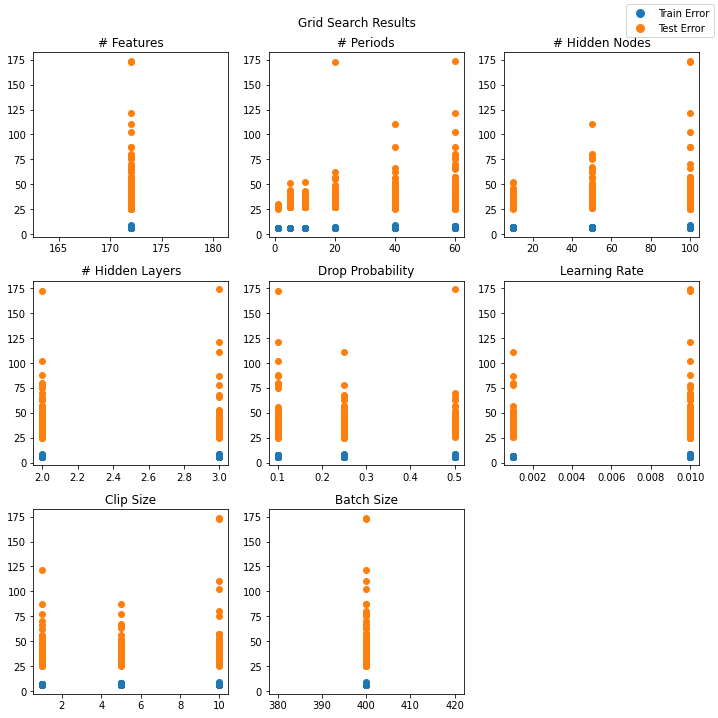

In [12]:
dh.visualizeGridSearch(grid_result)

In [13]:
resultdf = dh.resultDF(grid_result)

In [14]:
sorted_results = resultdf.sort_values(by=['Test Error'])
sorted_results

,Train Error,Test Error,# Features,# Periods,# Hidden Nodes,# Hidden Layers,Drop Probability,Learning Rate,Clip Size,Batch Size
160,6.488954,24.794556,172.0,40.0,100.0,2.0,0.25,0.010,1.0,400.0
588,5.759015,24.970272,172.0,1.0,100.0,2.0,0.25,0.010,10.0,400.0
131,6.753276,25.133804,172.0,60.0,10.0,3.0,0.10,0.010,1.0,400.0
413,7.434471,25.590578,172.0,60.0,100.0,2.0,0.50,0.010,5.0,400.0
34,6.343983,25.867720,172.0,40.0,100.0,3.0,0.10,0.001,1.0,400.0
...,...,...,...,...,...,...,...,...,...,...
557,7.419365,102.417343,172.0,60.0,100.0,2.0,0.10,0.010,10.0,400.0
496,6.366402,110.708725,172.0,40.0,50.0,3.0,0.25,0.001,10.0,400.0
143,7.308371,121.485924,172.0,60.0,100.0,3.0,0.10,0.010,1.0,400.0
555,6.886053,172.457062,172.0,20.0,100.0,2.0,0.10,0.010,10.0,400.0


## Fine Grid Search

In [15]:
best_model_id = sorted_results.index[0]

In [16]:
with open(grid_result_dir+str(best_model_id+1)+'.model','rb') as f:
    model = torch.load(f)
model.eval()


StockLSTM(
  (lstm): LSTM(172, 100, num_layers=2, batch_first=True, dropout=0.25)
  (dropout): Dropout(p=0.25, inplace=False)
  (fc): Linear(in_features=4000, out_features=1, bias=True)
)

In [17]:
# Configure search space
n_features = [df.shape[1]]
n_periods = [model.n_periods]
n_hidden = [model.n_hidden]
n_layers = [model.n_layers]
drop_prob = [model.drop_prob]
lr = [model.lr]
clip = [model.clip]
#batch_size = [1,5,10,20,40,60,120,240]
batch_size = [4,20,40,80,240,480,960]
epochs = [10,25,50,100,250,500]

In [19]:
batch_size = [40,80,240,480,960]
epochs = [25,50,100,250,500]

In [20]:
# use fine grid search to optimize hyperparameters
#fine_grid_result = []
dh.finegridSearch(grid_results = fine_grid_result,
              tickr=tickr,
                           n_features=n_features,
                           n_periods=n_periods,
                           n_hidden=n_hidden,
                           n_layers=n_layers,
                           drop_prob=drop_prob,
                           lr=lr,
                           clip=clip,
                           batch_size=batch_size,
                           data=df,
                           epochs=epochs,
                           n_test=n_test,
                           n_steps_out=1,
                          fpath=fine_grid_result_dir,
                           TRAIN_ON_GPU=TRAIN_ON_GPU,
                           TRAIN_ON_MULTI_GPUS=TRAIN_ON_MULTI_GPUS)

Hyper Parameter search across 25 different configurations.
Iteration: 1 |epochs: 25|periods: 40|hidden: 100|layers: 2|drop: 0.25|lr: 0.01|clip: 1
Training complete in 13m 1s
Iteration: 2 |epochs: 25|periods: 40|hidden: 100|layers: 2|drop: 0.25|lr: 0.01|clip: 1
Training complete in 5m 59s
Iteration: 3 |epochs: 25|periods: 40|hidden: 100|layers: 2|drop: 0.25|lr: 0.01|clip: 1
Training complete in 2m 13s
Iteration: 4 |epochs: 25|periods: 40|hidden: 100|layers: 2|drop: 0.25|lr: 0.01|clip: 1
Training complete in 1m 14s
Iteration: 5 |epochs: 25|periods: 40|hidden: 100|layers: 2|drop: 0.25|lr: 0.01|clip: 1
Training complete in 0m 44s
Iteration: 6 |epochs: 50|periods: 40|hidden: 100|layers: 2|drop: 0.25|lr: 0.01|clip: 1
Training complete in 26m 24s
Iteration: 7 |epochs: 50|periods: 40|hidden: 100|layers: 2|drop: 0.25|lr: 0.01|clip: 1
Training complete in 12m 25s
Iteration: 8 |epochs: 50|periods: 40|hidden: 100|layers: 2|drop: 0.25|lr: 0.01|clip: 1
Training complete in 4m 26s
Iteration: 9 |epoch

In [21]:
with open(model_dir+tickr+'fine_grid_search_result.bin','wb') as f:
    pickle.dump(fine_grid_result,f)

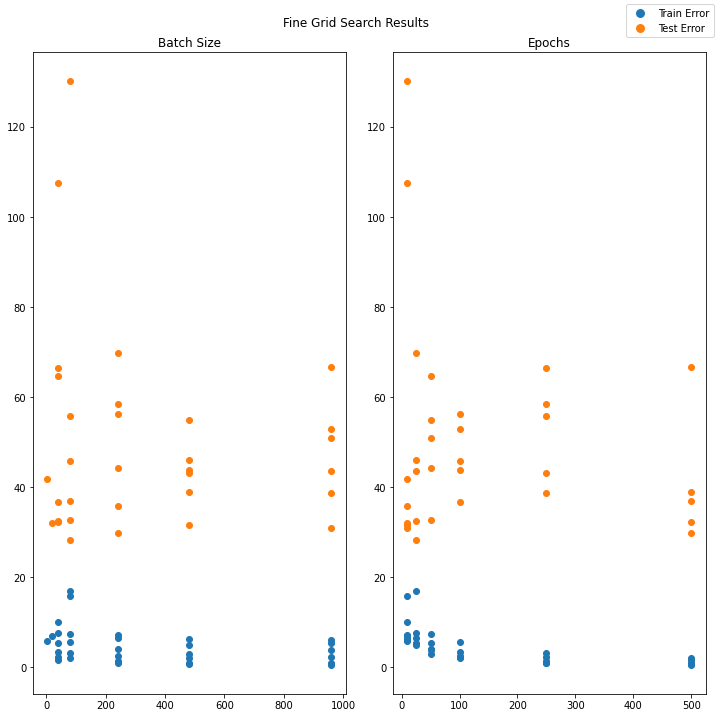

In [22]:
dh.visualizeFineGridSearch(fine_grid_result)

In [23]:
resultdf = dh.resultDFFine(fine_grid_result)

In [24]:
sorted_results = resultdf.sort_values(by=['Test Error'])
sorted_results

,Train Error,Test Error,# Features,# Periods,# Hidden Nodes,# Hidden Layers,Drop Probability,Learning Rate,Clip Size,Batch Size,Epochs
8,17.054480,28.343836,172.0,40.0,100.0,2.0,0.25,0.01,1.0,80.0,25.0
29,0.999112,29.832361,172.0,40.0,100.0,2.0,0.25,0.01,1.0,240.0,500.0
6,6.148367,30.882338,172.0,40.0,100.0,2.0,0.25,0.01,1.0,960.0,10.0
5,6.233642,31.681391,172.0,40.0,100.0,2.0,0.25,0.01,1.0,480.0,10.0
1,7.008996,32.113391,172.0,40.0,100.0,2.0,0.25,0.01,1.0,20.0,10.0
27,1.566005,32.198875,172.0,40.0,100.0,2.0,0.25,0.01,1.0,40.0,500.0
7,7.567760,32.520351,172.0,40.0,100.0,2.0,0.25,0.01,1.0,40.0,25.0
13,7.504043,32.688351,172.0,40.0,100.0,2.0,0.25,0.01,1.0,80.0,50.0
4,7.245372,35.891415,172.0,40.0,100.0,2.0,0.25,0.01,1.0,240.0,10.0
17,3.333175,36.723160,172.0,40.0,100.0,2.0,0.25,0.01,1.0,40.0,100.0


## Evaluate Final Model

In [9]:
#best_model_id = sorted_results.index[0]
#with open(fine_grid_result_dir+str(best_model_id+1)+'.model','rb') as f:
#    model = torch.load(f)
#model.eval()

with open(grid_result_dir+str(589)+'.model','rb') as f:
    model = torch.load(f)
model.eval()


StockLSTM(
  (lstm): LSTM(172, 100, num_layers=2, batch_first=True, dropout=0.25)
  (dropout): Dropout(p=0.25, inplace=False)
  (fc): Linear(in_features=100, out_features=1, bias=True)
)

Training RMSE: 5.518061567267453
Test RMSE: 26.97593265279558
Training MAE: 0.7015308530076101
Test MAE: 19.72716015841274
Training - Above Error: $0.69 (50.89%) Below Error: $-0.71 (49.11%)
Test - Above Error: $25.44 (24.32%) Below Error: $-17.89 (75.68%)


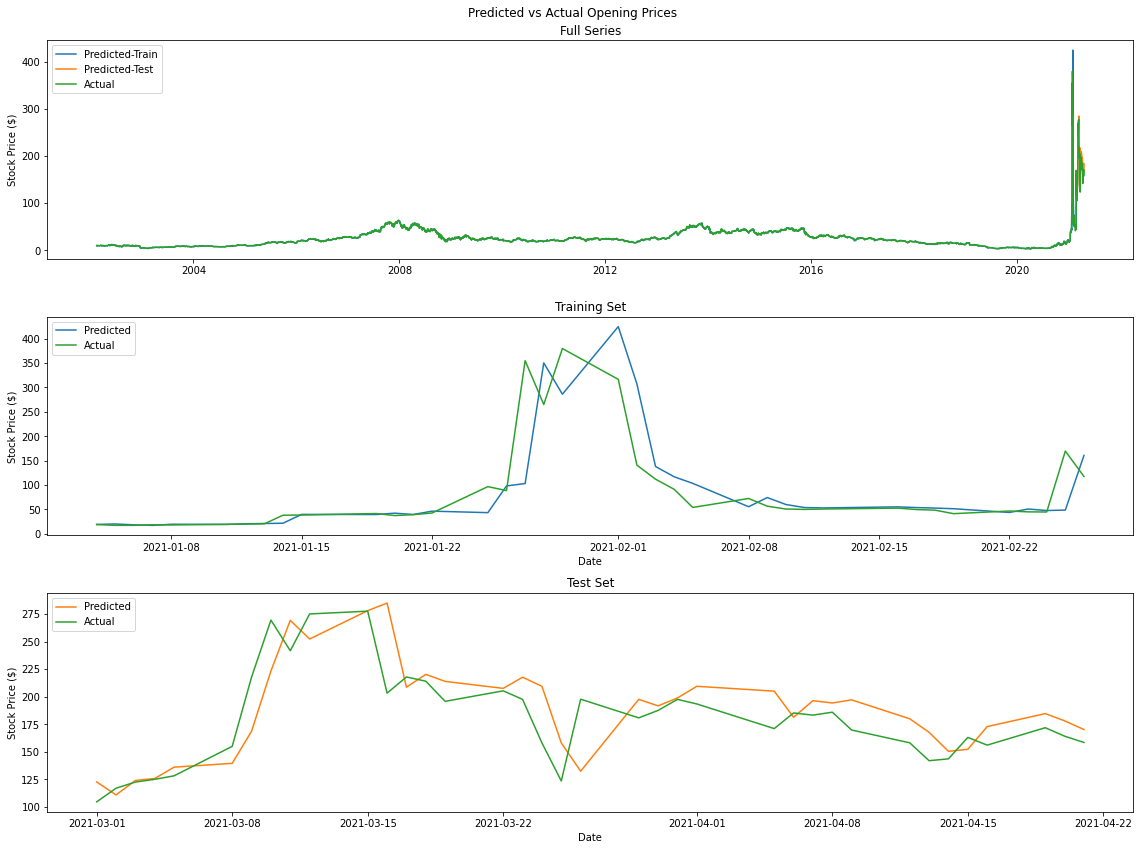

In [10]:
preds = dh.evaluateModel(model=model,
             input_data=df,
             output_data=output_data[:-1],
             scaler=scaler,
             n_steps_in=model.n_periods,
             n_steps_out=1,
             n_test=n_test)

In [11]:
preds.tail()

,Open,Raw_Predictions,Prediction_Type,Predicted
Date,,,,
2021-04-15,163.000000,0.060092,Test,152.197445
2021-04-16,156.000000,0.183280,Test,172.795028
2021-04-19,171.800003,0.036423,Test,184.591676
2021-04-20,164.139999,0.036502,Test,178.057550
2021-04-21,158.399994,0.077885,Test,170.131484


In [12]:
with open(pred_dir+tickr+'_pred.bin','wb') as f:
    pickle.dump(preds,f)

In [13]:
with open(final_model_dir+tickr+'_model.model','wb') as f:
    torch.save(model,f)

In [27]:
def plotPrediction(df):
    plt.style.use("seaborn-dark")
    for param in ['figure.facecolor', 'axes.facecolor', 'savefig.facecolor']:
        plt.rcParams[param] = 'black'#'#212946'  # bluish dark grey
    for param in ['text.color', 'axes.labelcolor', 'xtick.color', 'ytick.color']:
        plt.rcParams[param] = '0.9'  # very light grey
    background_color = 'black'

    colors = [
        '#08F7FE',  # teal/cyan
        '#FE53BB',  # pink
        
        '#00ff41',  # matrix green
        '#F5D300',  # yellow
    ]
    plt.rcParams.update({'font.size': 12})
    fig, axs = plt.subplots(3,figsize=(20,7))
    #fig.suptitle(f"Predicted vs Actual Opening Prices")
    
    axs[0].set_title('Full Series')
    axs[0].set_ylabel('Stock Price ($)')
    axs[0].plot(df[df['Prediction_Type']=='Training']['Predicted'], label='Predicted-Train', color=colors[2])
    axs[0].plot(df[df['Prediction_Type']=='Test']['Predicted'], label='Predicted-Test', color=colors[0])
    axs[0].plot(df['Open'], label='Actual', color=colors[3])

    n_shades = 10
    diff_linewidth = 1.05
    alpha_value = 0.3 / n_shades

    for n in range(1, n_shades+1):
        df[df['Prediction_Type']=='Training']['Predicted'].plot(
                linewidth=1+(diff_linewidth*n),
                alpha=alpha_value,
                legend=False,
                ax=axs[0],
                color=colors[2])
        df[df['Prediction_Type']=='Test']['Predicted'].plot(
                linewidth=1+(diff_linewidth*n),
                alpha=alpha_value,
                legend=False,
                ax=axs[0],
                color=colors[0])
        df['Open'].plot(
                linewidth=1+(diff_linewidth*n),
                alpha=alpha_value,
                legend=False,
                ax=axs[0],
                color=colors[3])
    legend_elements = [Line2D([0], [0], color=colors[2], label='Predicted-Train'),
                   Line2D([0], [0], color=colors[0], label='Predicted-Test'),
                      Line2D([0], [0], color=colors[3], label='Actual'),]
    #axs[0].get_legend().remove()
    axs[0].legend(handles=legend_elements,loc='upper left')
    
    axs[1].set_ylabel('Stock Price ($)')
    axs[1].set_xlabel('Date')
    axs[1].set_title('Training Set')
    axs[1].plot(df[df['Prediction_Type']=='Training']['Predicted']['2021-01-01':], label='Predicted', color=colors[2])
    axs[1].plot(df[df['Prediction_Type']=='Training']['Open']['2021-01-01':], label='Actual', color=colors[3])
    for n in range(1, n_shades+1):
        df[df['Prediction_Type']=='Training']['Predicted']['2021-01-01':].plot(
                linewidth=1+(diff_linewidth*n),
                alpha=alpha_value,
                legend=False,
                ax=axs[1],
                color=colors[2])
        df[df['Prediction_Type']=='Training']['Open']['2021-01-01':].plot(
                linewidth=1+(diff_linewidth*n),
                alpha=alpha_value,
                legend=False,
                ax=axs[1],
                color=colors[3])
    legend_elements = [Line2D([0], [0], color=colors[2], label='Predicted'),
                      Line2D([0], [0], color=colors[3], label='Actual'),]
    #axs[0].get_legend().remove()
    axs[1].legend(handles=legend_elements,loc='upper left')

    axs[2].set_ylabel('Stock Price ($)')
    axs[2].set_xlabel('Date')
    axs[2].set_title('Test Set')
    axs[2].plot(df[df['Prediction_Type']=='Test']['Predicted'], label='Predicted', color=colors[0])
    axs[2].plot(df[df['Prediction_Type']=='Test']['Open'], label='Actual', color=colors[3])
    for n in range(1, n_shades+1):
        df[df['Prediction_Type']=='Test']['Predicted'].plot(
                linewidth=1+(diff_linewidth*n),
                alpha=alpha_value,
                legend=False,
                ax=axs[2],
                color=colors[0])
        df[df['Prediction_Type']=='Test']['Open'].plot(
                linewidth=1+(diff_linewidth*n),
                alpha=alpha_value,
                legend=False,
                ax=axs[2],
                color=colors[3])
    legend_elements = [Line2D([0], [0], color=colors[0], label='Predicted'),
                      Line2D([0], [0], color=colors[3], label='Actual'),]
    #axs[0].get_legend().remove()
    axs[2].legend(handles=legend_elements,loc='upper left')

    fig.tight_layout()
    plt.show()

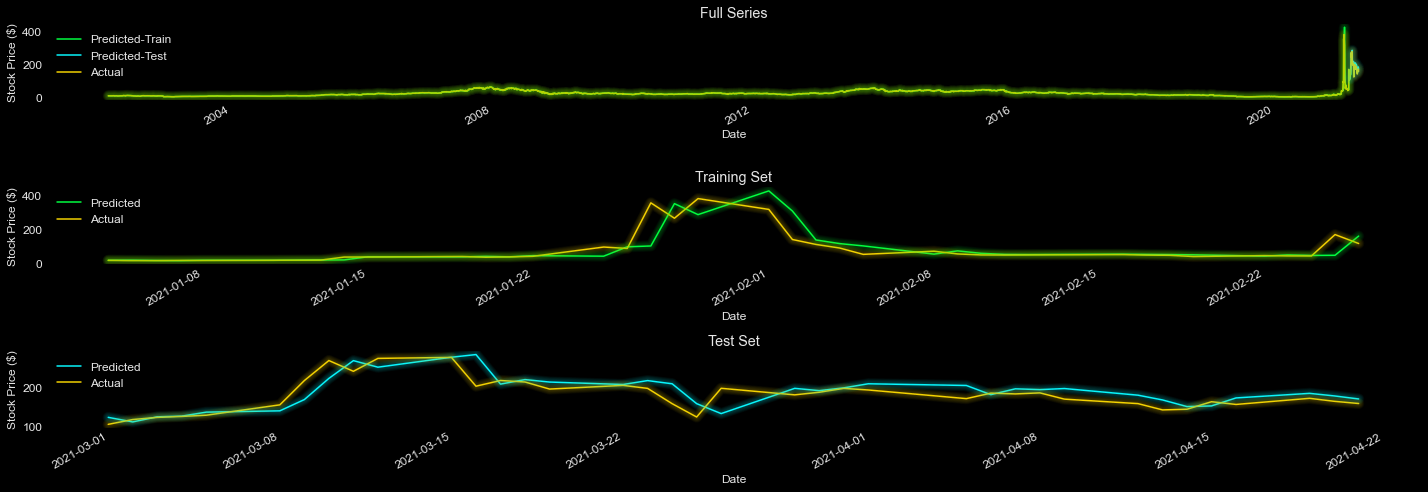

In [28]:
plotPrediction(preds)